In [30]:
!git clone https://github.com/manigalati/usad

Cloning into 'usad'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 89 (delta 3), reused 2 (delta 0), pack-reused 78
Receiving objects: 100% (89/89), 2.82 MiB | 4.92 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# from utils import *
# from usad import *

In [188]:
path = '/workspace/Automl/AutoEncoder/dataset/normal_25.csv'

In [189]:
path_a = '/workspace/Automl/AutoEncoder/dataset/anomaly_86.csv'

In [190]:
normal = pd.read_csv(path)
anomaly = pd.read_csv(path_a)

In [191]:
normal

,wavelength,x,y,z
0,0.0000,1.081055,-3.603516,2.041992
1,0.0005,0.600586,-3.803711,2.602539
2,0.0010,0.120117,-3.603516,2.882812
3,0.0015,-0.520508,-3.163086,3.002930
4,0.0020,-1.321289,-2.362305,3.163086
...,...,...,...,...
1995,0.9975,3.283203,-2.602539,-1.241211
1996,0.9980,3.163086,-2.882812,-0.800781
1997,0.9985,2.642578,-2.962891,-0.240234
1998,0.9990,2.082031,-3.203125,0.560547


In [192]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [193]:
normal = normal.iloc[:,1:]
normal

,1,2,3
0,0.662921,0.037234,0.802083
1,0.595506,0.010638,0.875000
2,0.528090,0.037234,0.911458
3,0.438202,0.095745,0.927083
4,0.325843,0.202128,0.947917
...,...,...,...
1995,0.971910,0.170213,0.375000
1996,0.955056,0.132979,0.432292
1997,0.882022,0.122340,0.505208
1998,0.803371,0.090426,0.609375


In [194]:
from sklearn import preprocessing

x = anomaly.values 
x_scaled = min_max_scaler.transform(x)
anomaly = pd.DataFrame(x_scaled)

In [195]:
anomaly = anomaly.iloc[:,1:]
anomaly

,1,2,3
0,1.022472,0.175532,0.302083
1,1.011236,0.090426,0.421875
2,0.971910,0.053191,0.484375
3,0.943820,0.015957,0.552083
4,0.887640,-0.021277,0.640625
...,...,...,...
1995,0.814607,0.622340,0.104167
1996,0.853933,0.569149,0.119792
1997,0.910112,0.500000,0.130208
1998,0.955056,0.404255,0.177083


In [363]:
window_size=12

windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(1988, 12, 3)

In [364]:
windows_anomaly=anomaly.values[np.arange(window_size)[None, :] + np.arange(anomaly.shape[0]-window_size)[:, None]]
windows_anomaly.shape

(1988, 12, 3)

In [380]:
import torch.utils.data as data_utils

BATCH_SIZE =  100
N_EPOCHS = 100
hidden_size = 10
device = 'cuda'

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(windows_normal_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(windows_normal_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(windows_anomaly, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [366]:
next(iter(test_loader)).shape

torch.Size([100, 12, 3])

In [367]:
class Encoder(nn.Module):
    def __init__(self,  input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1):
        super().__init__()
        self.input_size = input_size #input size
        self.hidden_size_1 = hidden_size_1 #hidden state == output_vector
        self.hidden_size_2 = hidden_size_2 #hidden state == output_vector
        self.seq_length = seq_length #sequence length
        self.num_layers = num_layers #number of layers == 몇층

        
        self.lstm_1 = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size_1,
                      num_layers=self.num_layers, batch_first=True)
        
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.hidden_size_2,
                      num_layers=self.num_layers, batch_first=True)


    def forward(self, w):
        out_1, _ = self.lstm_1(w)
        
        return self.lstm_2(out_1)


In [368]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1):
        super().__init__()
        self.input_size = input_size #input size
        self.hidden_size_1 = hidden_size_1 #hidden state == output_vector
        self.hidden_size_2 = hidden_size_2 #hidden state == output_vector
        self.seq_length = seq_length #sequence length
        self.num_layers = num_layers #number of layers == 몇층

        self.lstm_1 = nn.LSTM(input_size=self.hidden_size_2, hidden_size=self.hidden_size_1,
                      num_layers=self.num_layers, batch_first=True)
        
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.input_size,
                      num_layers=self.num_layers, batch_first=True)


    def forward(self, z):
        out_1, _ = self.lstm_1(z)

        return self.lstm_2(out_1)

In [296]:
class UsadModel(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1):
        super().__init__()
        self.input_size = input_size #input size
        self.hidden_size_1 = hidden_size_1 #hidden state == output_vector
        self.hidden_size_2 = hidden_size_2 #hidden state == output_vector
        self.seq_length = seq_length #sequence length
        self.num_layers = num_layers #number of layers == 몇층
        
        self.encoder = Encoder(input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1)
        self.decoder1 = Decoder(input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1)
        self.decoder2 = Decoder(input_size, hidden_size_1, hidden_size_2, seq_length, num_layers = 1)
        
    def forward(self, x, n):
        out_, _ = self.encoder(x)        
        out_.to(device)
        w1, _= self.decoder1(out_)
        w1.to(device)
        w2, _ = self.decoder2(out_)
        w2.to(device)
        self.encoder(w1)
        w3, _ = self.decoder2(self.encoder(w1)[0])
        w3.to(device)

        loss1 = 1/n*torch.mean((x-w1)**2)+(1-1/n)*torch.mean((x-w3)**2)
        loss2 = 1/n*torch.mean((x-w2)**2)-(1-1/n)*torch.mean((x-w3)**2)
        
        return loss1, loss2, out_, w2, w3

In [297]:
model = UsadModel(3,64,32,12)

In [298]:
optimizer1 = torch.optim.Adam(list(model.encoder.parameters())+list(model.decoder1.parameters()))
optimizer2 = torch.optim.Adam(list(model.encoder.parameters())+list(model.decoder2.parameters()))
model.to(device)

UsadModel(
  (encoder): Encoder(
    (lstm_1): LSTM(3, 64, batch_first=True)
    (lstm_2): LSTM(64, 32, batch_first=True)
  )
  (decoder1): Decoder(
    (lstm_1): LSTM(32, 64, batch_first=True)
    (lstm_2): LSTM(64, 3, batch_first=True)
  )
  (decoder2): Decoder(
    (lstm_1): LSTM(32, 64, batch_first=True)
    (lstm_2): LSTM(64, 3, batch_first=True)
  )
)

In [306]:
def train(model, train_loader, val_loader, epoch, optimizer1, optimizer2, device='cuda'):
    
    model.train()
    
    losses_train = []
    for batch in train_loader:
        loss1, loss2, out_,w2,w3 = model(batch.type(torch.FloatTensor).to(device),epoch+1)
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer1.step()
        optimizer2.step()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        losses_train.append([loss1.item(),loss2.item()])
    
    losses_train = np.array(losses_train)
    train_loss_1 = np.mean(losses_train[:,0])
    train_loss_2 = np.mean(losses_train[:,1])
    
    
    
    # validation
    model.eval()
    
    losses_val = []
    for batch in val_loader:
        loss1_v, loss2_v, out_, w2, w3 = model(batch.type(torch.FloatTensor).to(device), epoch+1)

        losses_val.append([loss1_v.item(), loss2_v.item()])
        
    losses_val = np.array(losses_val)
    val_loss_1 = np.mean(losses_val[:,0])
    val_loss_2 = np.mean(losses_val[:,1])
        
    return train_loss_1, train_loss_2, val_loss_1, val_loss_2

In [307]:
epochs =50
for epoch in range(epochs):
    train_loss_1, train_loss_2, val_loss_1, val_loss_2 = train(model, train_loader, val_loader, epochs, optimizer1, optimizer2)
    print(f'epoch - {epoch}  train_loss_1 - {train_loss_1}  train_loss_2 - {train_loss_2}  val_loss_1 - {val_loss_1}  val_loss_2 - {val_loss_2}')

epoch - 0  train_loss_1 - 0.11101343715563416  train_loss_2 - -0.10669461218640208  val_loss_1 - 0.11205313540995121  val_loss_2 - -0.1076879445463419
epoch - 1  train_loss_1 - 0.11010643001645803  train_loss_2 - -0.10581521643325686  val_loss_1 - 0.11131906323134899  val_loss_2 - -0.10697640664875507
epoch - 2  train_loss_1 - 0.10949949873611331  train_loss_2 - -0.10522777820006013  val_loss_1 - 0.11081575602293015  val_loss_2 - -0.106491195037961
epoch - 3  train_loss_1 - 0.10906036011874676  train_loss_2 - -0.1048107291571796  val_loss_1 - 0.11043685302138329  val_loss_2 - -0.10615018382668495
epoch - 4  train_loss_1 - 0.10863283229991794  train_loss_2 - -0.10448685614392161  val_loss_1 - 0.11000966280698776  val_loss_2 - -0.10593512654304504
epoch - 5  train_loss_1 - 0.10613834718242288  train_loss_2 - -0.10238790279254317  val_loss_1 - 0.10749920085072517  val_loss_2 - -0.10405397787690163
epoch - 6  train_loss_1 - 0.09757364355027676  train_loss_2 - -0.09450158942490816  val_loss

In [334]:
def testing(model, test_loader, alpha=.5, beta=.5, device = 'cuda'):
    results =[]
    for batch in test_loader:
        batch = batch.type(torch.FloatTensor).to(device)
        out_, _ = model.encoder(batch)
        out_.to(device)
        w1, _ = model.decoder1(out_)
        w1.to(device)
        w2, _ = model.decoder2(model.encoder(w1)[0])
        w2.to(device)
        
        
        results.append(alpha*torch.mean((batch-w1)**2, axis=1) + beta*torch.mean((batch-w2)**2, axis=1))
    
    return results

In [351]:
results = testing(model,test_loader)

In [343]:
len(test_loader)

20

19

In [358]:
results[0].shape

torch.Size([100, 3])

In [404]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.ones((windows_anomaly.shape[0]*windows_anomaly.shape[2]))])

In [410]:
y_pred

array([0.0164653 , 0.00503381, 0.00261857, ..., 0.00176805, 0.00422034,
       0.0013509 ], dtype=float32)

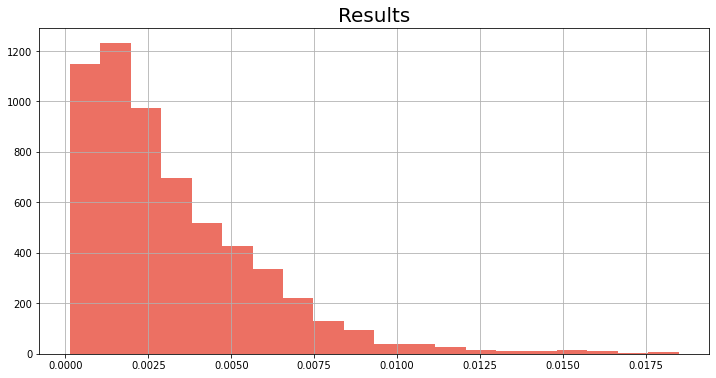

In [407]:
histogram(y_test,y_pred)

In [408]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

In [409]:
threshold=ROC(y_test,y_pred)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [391]:
y_pred[:5]

array([0.0164653 , 0.00503381, 0.00261857, 0.01571186, 0.00546734],
      dtype=float32)

In [394]:
windows_anomaly

array([[[ 1.02247191,  0.17553191,  0.30208333],
        [ 1.01123596,  0.09042553,  0.421875  ],
        [ 0.97191011,  0.05319149,  0.484375  ],
        ...,
        [ 0.42696629,  0.08510638,  0.94791667],
        [ 0.33146067,  0.15425532,  0.96875   ],
        [ 0.21910112,  0.25531915,  0.97916667]],

       [[ 1.01123596,  0.09042553,  0.421875  ],
        [ 0.97191011,  0.05319149,  0.484375  ],
        [ 0.94382022,  0.01595745,  0.55208333],
        ...,
        [ 0.33146067,  0.15425532,  0.96875   ],
        [ 0.21910112,  0.25531915,  0.97916667],
        [ 0.11235955,  0.36702128,  0.95833333]],

       [[ 0.97191011,  0.05319149,  0.484375  ],
        [ 0.94382022,  0.01595745,  0.55208333],
        [ 0.88764045, -0.0212766 ,  0.640625  ],
        ...,
        [ 0.21910112,  0.25531915,  0.97916667],
        [ 0.11235955,  0.36702128,  0.95833333],
        [ 0.08426966,  0.43617021,  0.91666667]],

       ...,

       [[ 0.06179775,  0.82978723,  0.57291667],
        [ 0

In [383]:
windows_anomaly.shape

(1988, 12, 3)

In [384]:
y_pred.shape

(5964,)

In [385]:
y_test.shape

(3976,)

In [ ]:
epochs = 501
for i in range(epochs):
    model.train()
    
    output = model(tensor_x)
    loss = criterion(output, tensor_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

In [87]:
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

In [88]:
def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward(retain_graph=True)
            loss2.backward()
            optimizer1.step()
            optimizer2.step()
            optimizer1.zero_grad()
            optimizer2.zero_grad()
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [89]:
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [ ]:

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [45]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.1050, val_loss2: 0.1047
Epoch [1], val_loss1: 0.1048, val_loss2: -0.0006
Epoch [2], val_loss1: 0.1047, val_loss2: -0.0358
Epoch [3], val_loss1: 0.1046, val_loss2: -0.0535
Epoch [4], val_loss1: 0.1048, val_loss2: -0.0647
Epoch [5], val_loss1: 0.1052, val_loss2: -0.0731
Epoch [6], val_loss1: 0.1051, val_loss2: -0.0791
Epoch [7], val_loss1: 0.0989, val_loss2: -0.0782
Epoch [8], val_loss1: 0.0866, val_loss2: -0.0710
Epoch [9], val_loss1: 0.0646, val_loss2: -0.0541
Epoch [10], val_loss1: 0.0397, val_loss2: -0.0332
Epoch [11], val_loss1: 0.0247, val_loss2: -0.0206
Epoch [12], val_loss1: 0.0164, val_loss2: -0.0140
Epoch [13], val_loss1: 0.0116, val_loss2: -0.0101
Epoch [14], val_loss1: 0.0083, val_loss2: -0.0074
Epoch [15], val_loss1: 0.0062, val_loss2: -0.0056
Epoch [16], val_loss1: 0.0049, val_loss2: -0.0044
Epoch [17], val_loss1: 0.0040, val_loss2: -0.0036
Epoch [18], val_loss1: 0.0033, val_loss2: -0.0030
Epoch [19], val_loss1: 0.0028, val_loss2: -0.0026
Epoch [20],

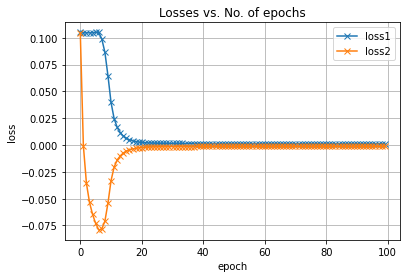

In [46]:
plot_history(history)

In [47]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "210616_model.pth")

In [48]:
checkpoint = torch.load("210616_model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [49]:
results=testing(model,test_loader)

In [53]:
results[0].shape

torch.Size([100])

In [52]:
len(results)

30

In [381]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_anomaly.shape[0]),
                       np.ones(windows_anomaly.shape[0])])

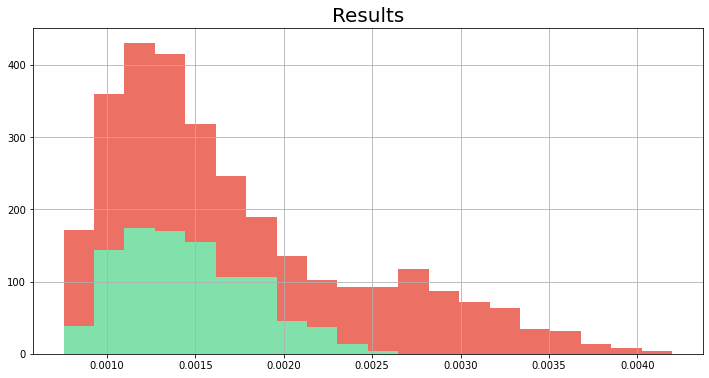

In [60]:
histogram(y_test,y_pred)

In [62]:
y_pred

array([0.00118295, 0.00129489, 0.00116065, ..., 0.00114251, 0.00108243,
       0.0011382 ], dtype=float32)

In [67]:
len(y_test[y_test==1])

1988

In [69]:
for i, y in enumerate(y_test):
    print(f'{i} : {y}')

0 : 0.0
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.0
9 : 0.0
10 : 0.0
11 : 0.0
12 : 0.0
13 : 0.0
14 : 0.0
15 : 0.0
16 : 0.0
17 : 0.0
18 : 0.0
19 : 0.0
20 : 0.0
21 : 0.0
22 : 0.0
23 : 0.0
24 : 0.0
25 : 0.0
26 : 0.0
27 : 0.0
28 : 0.0
29 : 0.0
30 : 0.0
31 : 0.0
32 : 0.0
33 : 0.0
34 : 0.0
35 : 0.0
36 : 0.0
37 : 0.0
38 : 0.0
39 : 0.0
40 : 0.0
41 : 0.0
42 : 0.0
43 : 0.0
44 : 0.0
45 : 0.0
46 : 0.0
47 : 0.0
48 : 0.0
49 : 0.0
50 : 0.0
51 : 0.0
52 : 0.0
53 : 0.0
54 : 0.0
55 : 0.0
56 : 0.0
57 : 0.0
58 : 0.0
59 : 0.0
60 : 0.0
61 : 0.0
62 : 0.0
63 : 0.0
64 : 0.0
65 : 0.0
66 : 0.0
67 : 0.0
68 : 0.0
69 : 0.0
70 : 0.0
71 : 0.0
72 : 0.0
73 : 0.0
74 : 0.0
75 : 0.0
76 : 0.0
77 : 0.0
78 : 0.0
79 : 0.0
80 : 0.0
81 : 0.0
82 : 0.0
83 : 0.0
84 : 0.0
85 : 0.0
86 : 0.0
87 : 0.0
88 : 0.0
89 : 0.0
90 : 0.0
91 : 0.0
92 : 0.0
93 : 0.0
94 : 0.0
95 : 0.0
96 : 0.0
97 : 0.0
98 : 0.0
99 : 0.0
100 : 0.0
101 : 0.0
102 : 0.0
103 : 0.0
104 : 0.0
105 : 0.0
106 : 0.0
107 : 0.0
108 : 0.0
109 : 0.0
110 : 0.0


1419 : 1.0
1420 : 1.0
1421 : 1.0
1422 : 1.0
1423 : 1.0
1424 : 1.0
1425 : 1.0
1426 : 1.0
1427 : 1.0
1428 : 1.0
1429 : 1.0
1430 : 1.0
1431 : 1.0
1432 : 1.0
1433 : 1.0
1434 : 1.0
1435 : 1.0
1436 : 1.0
1437 : 1.0
1438 : 1.0
1439 : 1.0
1440 : 1.0
1441 : 1.0
1442 : 1.0
1443 : 1.0
1444 : 1.0
1445 : 1.0
1446 : 1.0
1447 : 1.0
1448 : 1.0
1449 : 1.0
1450 : 1.0
1451 : 1.0
1452 : 1.0
1453 : 1.0
1454 : 1.0
1455 : 1.0
1456 : 1.0
1457 : 1.0
1458 : 1.0
1459 : 1.0
1460 : 1.0
1461 : 1.0
1462 : 1.0
1463 : 1.0
1464 : 1.0
1465 : 1.0
1466 : 1.0
1467 : 1.0
1468 : 1.0
1469 : 1.0
1470 : 1.0
1471 : 1.0
1472 : 1.0
1473 : 1.0
1474 : 1.0
1475 : 1.0
1476 : 1.0
1477 : 1.0
1478 : 1.0
1479 : 1.0
1480 : 1.0
1481 : 1.0
1482 : 1.0
1483 : 1.0
1484 : 1.0
1485 : 1.0
1486 : 1.0
1487 : 1.0
1488 : 1.0
1489 : 1.0
1490 : 1.0
1491 : 1.0
1492 : 1.0
1493 : 1.0
1494 : 1.0
1495 : 1.0
1496 : 1.0
1497 : 1.0
1498 : 1.0
1499 : 1.0
1500 : 1.0
1501 : 1.0
1502 : 1.0
1503 : 1.0
1504 : 1.0
1505 : 1.0
1506 : 1.0
1507 : 1.0
1508 : 1.0
1509 : 1.0

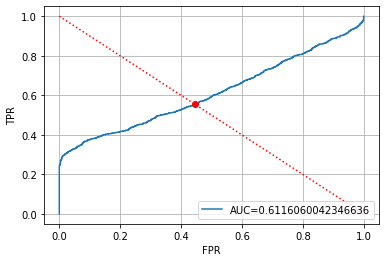

In [71]:
threshold=ROC(y_test,y_pred)

In [376]:
threshold

array([0.00147691], dtype=float32)

In [74]:
for i, y in enumerate(y_pred):
    print(f'{i} : {y}')

0 : 0.0011829525465145707
1 : 0.0012948939111083746
2 : 0.0011606529587879777
3 : 0.0010358556173741817
4 : 0.0010655430378392339
5 : 0.001227084081619978
6 : 0.001246303552761674
7 : 0.0012169647961854935
8 : 0.0011550297494977713
9 : 0.0010574954794719815
10 : 0.0011210332158952951
11 : 0.0012157449964433908
12 : 0.0011601420119404793
13 : 0.0010702498257160187
14 : 0.0010764666367322206
15 : 0.0010773856192827225
16 : 0.001123308204114437
17 : 0.0012221464421600103
18 : 0.0013651764020323753
19 : 0.0013857904123142362
20 : 0.0012525827623903751
21 : 0.0011979284463450313
22 : 0.0012318522203713655
23 : 0.0011806748807430267
24 : 0.0011935888323932886
25 : 0.0012127619702368975
26 : 0.0011515798978507519
27 : 0.0011542323045432568
28 : 0.0012101291213184595
29 : 0.0012728215660899878
30 : 0.0012433934025466442
31 : 0.001100644120015204
32 : 0.0009636180475354195
33 : 0.0011585205793380737
34 : 0.001293636392802
35 : 0.001306326361373067
36 : 0.0011514255311340094
37 : 0.0011021613609

1723 : 0.0030769393779337406
1724 : 0.003173419274389744
1725 : 0.003239538287743926
1726 : 0.003341353964060545
1727 : 0.003414032282307744
1728 : 0.003338244743645191
1729 : 0.0029760519973933697
1730 : 0.0028689675964415073
1731 : 0.003027687780559063
1732 : 0.0030567562207579613
1733 : 0.0030678275506943464
1734 : 0.003061436116695404
1735 : 0.0031604901887476444
1736 : 0.0031753485091030598
1737 : 0.003036289010196924
1738 : 0.003063186537474394
1739 : 0.0031122660730034113
1740 : 0.002968977903947234
1741 : 0.0033149542286992073
1742 : 0.0034896093420684338
1743 : 0.0032184075098484755
1744 : 0.0030752327293157578
1745 : 0.0028627405408769846
1746 : 0.002694846596568823
1747 : 0.0026617348194122314
1748 : 0.0027632820419967175
1749 : 0.0029610139317810535
1750 : 0.0032222848385572433
1751 : 0.0034358352422714233
1752 : 0.003807039698585868
1753 : 0.003961046226322651
1754 : 0.0039303540252149105
1755 : 0.0040882304310798645
1756 : 0.004024813883006573
1757 : 0.003958932124078274


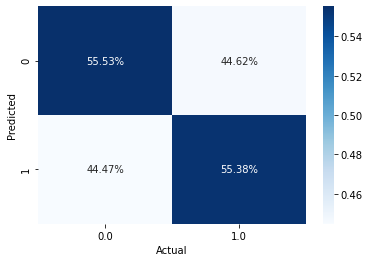

In [72]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)